In [170]:
import pandas as pd
from collections import Counter
from datetime import datetime
import json
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

In [167]:
experts = pd.read_csv('twitter_accounts_complete.csv')
account_info = json.load(open('cleaned_account_info.json'))

In [12]:
for ins in ['aei', 'brookings', 'heritage']:
    total = experts[experts['institution']==ins]
    non_twitter = Counter(total['twitter'])['-1']
    print(ins, len(total), non_twitter, 1-non_twitter/len(total))

aei 119 37 0.6890756302521008
brookings 424 130 0.6933962264150944
heritage 124 36 0.7096774193548387


## Join Time

In [17]:
experts['join_time'] = experts['twitter'].apply(lambda x: account_info[x]['join_time'] 
                                                if x in account_info else 0)
cut = experts[experts['join_time'] != 0].copy()
cut['join_time'] = cut['join_time'].apply(lambda x: datetime.strptime(x[7:], '%B %Y'))

In [143]:
lst = sorted(cut['join_time'])
lst = pd.date_range(start=lst[0],end=lst[-1], freq='M')

In [144]:
num_people = [sum(cut['join_time']<=i) for i in lst]
num_aei = [sum(cut[cut['institution']=='aei']['join_time']<=i) for i in lst]
num_brookings = [sum(cut[cut['institution']=='brookings']['join_time']<=i) for i in lst]
num_heritage = [sum(cut[cut['institution']=='heritage']['join_time']<=i) for i in lst]

In [145]:
def growth_rate(num_lst):
    rate = [0]
    for i in range(1, len(num_lst)):
        if num_lst[i-1] == 0: rate.append(0); continue
        rate.append((num_lst[i]-num_lst[i-1])/ num_lst[i-1])
    return rate

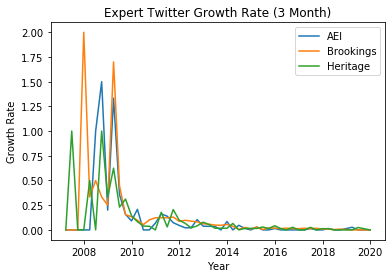

In [142]:
#sns.lineplot(x=lst, y = growth_rate(num_people), label = 'Total', color = 'black')
sns.lineplot(x=lst, y = growth_rate(num_aei), label = 'AEI')
sns.lineplot(x=lst, y = growth_rate(num_brookings), label = 'Brookings')
sns.lineplot(x=lst, y = growth_rate(num_heritage), label = 'Heritage')
plt.title('Expert Twitter Growth Rate (3 Month)')
plt.xlabel('Year'); plt.ylabel('Growth Rate')
plt.legend(); plt.show()

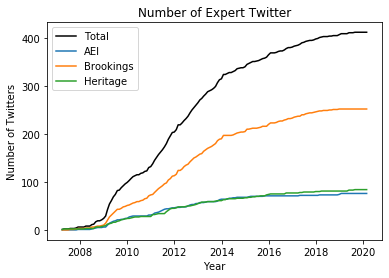

In [146]:
sns.lineplot(x=lst, y = num_people, label = 'Total', color = 'black')
sns.lineplot(x=lst, y = num_aei, label = 'AEI')
sns.lineplot(x=lst, y = num_brookings, label = 'Brookings')
sns.lineplot(x=lst, y = num_heritage, label = 'Heritage')
plt.title('Number of Expert Twitter')
plt.xlabel('Year'); plt.ylabel('Number of Twitters')
plt.legend(); plt.show()

## Number of Followers/ Following

In [203]:
experts = pd.read_csv('twitter_accounts_2.csv')
follower = json.load(open('cleaned_follower.json'))
following = json.load(open('cleaned_following.json'))

In [204]:
experts['num_follower'] = experts['twitter'].apply(lambda x: len(follower[x]) 
                                                   if x in follower else -1)
experts['num_following'] = experts['twitter'].apply(lambda x: len(following[x]) 
                                                   if x in following else -1)

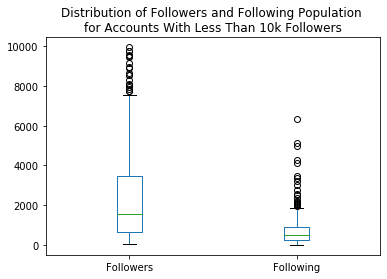

In [282]:
data = cut[['true_followers', 'true_following']].copy()
data = data[data['true_followers']<10000]
data.columns = ['Followers', 'Following']
data.boxplot(grid=False, showbox=True)
plt.title('Distribution of Followers and Following Population \nfor Accounts With Less Than 10k Followers')
plt.show()

## Account Types

In [295]:
account_type = json.load(open('account_type.json'))

In [298]:
for key in account_type:
    print(key, len(set(account_type[key])))

house115 435
senate115 102
sen116 99
rep116 433
news_outlet 4514
government_agency 3897


## Number of Citations

In [373]:
data = pd.read_csv('data_analysis.csv')

In [374]:
for ins in ['aei', 'brookings', 'heritage']:
    total = data[data['institution']==ins]
    non_twitter = Counter(total['num_citation'])[0]
    print(ins, len(total), non_twitter, 1-non_twitter/len(total))

aei 76 76 0.0
brookings 246 175 0.28861788617886175
heritage 84 79 0.059523809523809534


In [398]:
position_dict

{1: 'visiting fellow',
 2: 'resident fellow',
 3: 'senior fellow',
 4: 'leadership'}

In [397]:
position_codes = {
    'leadership': 4,
    'senior fellow': 3,
    'Resident Scholar':2,
    "research fellow": 2,
    'research Fellow':2,
    'visiting fellow': 1,
    'Visiting Fellow/Scholar':1,
    'visiting Fellow/Scholar':1,
    'nonresident fellow': 1,
    'assistant': 0,
    'former fellow': -1,
    'unclear':-1,
    np.NAN: -1,
}
cut = data[data['num_citation']>0].copy()
cut['position'] = cut['position'].apply(lambda x: position_dict[x])

[]

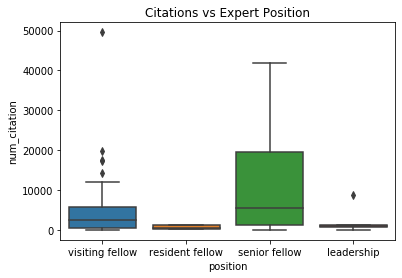

In [396]:
sns.boxplot(y = 'num_citation', x= 'position', data = cut,
            order = ['visiting fellow', 'resident fellow', 'senior fellow', 'leadership'])
#plt.xticks(['visiting fellow', 'resident fellow', 'senior fellow', 'leadership'])
plt.title("Citations vs Expert Position")
plt.plot()

## Frequency of Original and Total Tweets

freq_original    2.256664
freq_total       3.721670
dtype: float64


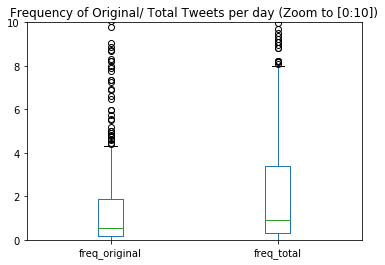

In [353]:
data = data[['freq_original', 'freq_total']].copy()
print(data.mean())
data.boxplot(grid=False)
plt.title('Frequency of Original/ Total Tweets per day (Zoom to [0:10])')
plt.ylim([0, 10])
plt.show()

In [345]:
data = data.rename(columns={"true_followers": "num_followers", 
                            "true_following": "num_following"})

In [351]:
from scipy import stats
import statsmodels.api as sm

#data = pd.read_csv('data_analysis.csv')
lst = ['name', 'twitter', 'institution', 'inner_degree', 'inner_betweeness',
       'freq_original', 'freq_total']
X = data.drop(lst, axis=1)
#y = data['freq_original']
y = data['freq_total']
print('                     Model: Y = Frequency of Total Tweets')
model = sm.OLS(y, sm.add_constant(X)).fit()
print(model.summary())

                     Model: Y = Frequency of Total Tweets
                            OLS Regression Results                            
Dep. Variable:             freq_total   R-squared:                       0.428
Model:                            OLS   Adj. R-squared:                  0.414
Method:                 Least Squares   F-statistic:                     29.57
Date:                Mon, 25 May 2020   Prob (F-statistic):           2.72e-42
Time:                        10:34:13   Log-Likelihood:                -1291.9
No. Observations:                 406   AIC:                             2606.
Df Residuals:                     395   BIC:                             2650.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------

In [340]:
X = data.drop(lst, axis=1)
print(X.columns)
y = data['freq_total']
model = sm.OLS(y, sm.add_constant(X)).fit()
print(model.summary())

Index(['true_followers', 'true_following', 'position', 'num_citation',
       'gov_followers', 'congress_followers', 'news_followers',
       'gov_following', 'congress_following', 'news_following'],
      dtype='object')
                            OLS Regression Results                            
Dep. Variable:             freq_total   R-squared:                       0.428
Model:                            OLS   Adj. R-squared:                  0.414
Method:                 Least Squares   F-statistic:                     29.57
Date:                Mon, 25 May 2020   Prob (F-statistic):           2.72e-42
Time:                        10:24:14   Log-Likelihood:                -1291.9
No. Observations:                 406   AIC:                             2606.
Df Residuals:                     395   BIC:                             2650.
Df Model:                          10                                         
Covariance Type:            nonrobust                              